In [32]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [127]:
def load_image(url, angle=0): 
    image = Image.open(url).rotate(angle)
    image = np.array(image)
    image = image / 255
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float()
    return image

In [34]:
train_x = [load_image(f'Resized_Dataset\\train\\{i}') for i in os.listdir("Resized_Dataset\\train")]
train_y = [0 if (i.split('_')[1])=="healthy.jpg" else 1 for i in os.listdir("Resized_Dataset\\train")]
test_x = [load_image(f'Resized_Dataset\\test\\{i}') for i in os.listdir("Resized_Dataset\\test")]
test_y = [0 if (i.split('_')[1])=="healthy.jpg" else 1 for i in os.listdir("Resized_Dataset\\test")]
print(len(train_x), len(train_y), len(test_x), len(test_y))
#train_x = [load_image(f') for i in range(1, 50001)]

160 160 40 40


In [35]:
train_x = torch.stack(train_x)
train_y = torch.tensor(train_y)

test_x = torch.stack(test_x)
test_y = torch.tensor(test_y)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([160, 3, 224, 224]) torch.Size([160]) torch.Size([40, 3, 224, 224]) torch.Size([40])


In [36]:
# Making Dataloader
batch_size = 16
train_data = torch.utils.data.TensorDataset(train_x, train_y)
test_data = torch.utils.data.TensorDataset(test_x, test_y)
torch.manual_seed(42)               # Set seed for reproducibility
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [103]:
class VGG1(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(10*112*112, 30),
            nn.ReLU(),
            nn.Linear(30, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out
    
class VGG3(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(20*28*28, 10),
            nn.ReLU(),
            nn.Linear(10, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out
    
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),

            nn.Linear(4096, 1000),
            nn.ReLU(),

            nn.Linear(1000, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out



In [104]:
model = VGG3().to(device)
# Loss and optimizer
# Binary Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [105]:
print(len(train_loader))

10


In [106]:
for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    print(images.shape)
    print(labels)
    break

torch.Size([16, 3, 224, 224])
tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1])


In [ ]:
# Train the model
total_step = len(train_loader)
num_epochs = 60
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/20], Step [1/10], Loss: 0.0137
Epoch [1/20], Step [2/10], Loss: 0.0297
Epoch [1/20], Step [3/10], Loss: 0.0270
Epoch [1/20], Step [4/10], Loss: 0.0222
Epoch [1/20], Step [5/10], Loss: 0.0254
Epoch [1/20], Step [6/10], Loss: 0.0229
Epoch [1/20], Step [7/10], Loss: 0.0121
Epoch [1/20], Step [8/10], Loss: 0.0311
Epoch [1/20], Step [9/10], Loss: 0.0344
Epoch [1/20], Step [10/10], Loss: 0.0274
Epoch [2/20], Step [1/10], Loss: 0.0185
Epoch [2/20], Step [2/10], Loss: 0.0184
Epoch [2/20], Step [3/10], Loss: 0.0189
Epoch [2/20], Step [4/10], Loss: 0.0177
Epoch [2/20], Step [5/10], Loss: 0.0274
Epoch [2/20], Step [6/10], Loss: 0.0168
Epoch [2/20], Step [7/10], Loss: 0.0176
Epoch [2/20], Step [8/10], Loss: 0.0162
Epoch [2/20], Step [9/10], Loss: 0.0186
Epoch [2/20], Step [10/10], Loss: 0.0285
Epoch [3/20], Step [1/10], Loss: 0.0153
Epoch [3/20], Step [2/10], Loss: 0.0138
Epoch [3/20], Step [3/10], Loss: 0.0282
Epoch [3/20], Step [4/10], Loss: 0.0160
Epoch [3/20], Step [5/10], Loss: 0.015

In [111]:
# Calculate Accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 40 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 40 test images: 87.5 %


Predicted: 1, Actual: 0
158_healthy.jpg


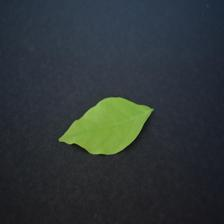


Predicted: 1, Actual: 0
186_healthy.jpg


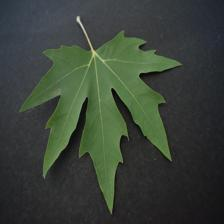


Predicted: 1, Actual: 0
5_healthy.jpg


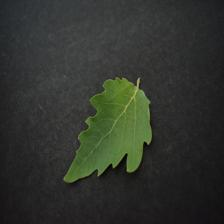


Predicted: 1, Actual: 0
85_healthy.jpg


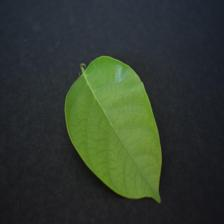


Predicted: 1, Actual: 0
91_healthy.jpg


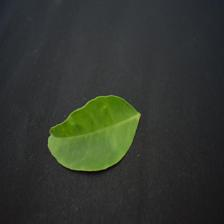

In [112]:
# Let us view the miscassified images
test_paths = os.listdir("Resized_Dataset\\test")
model.eval()
for path in test_paths:
    image = load_image(f'Resized_Dataset\\test\\{path}').unsqueeze(0).to(device)
    label = 0 if (path.split('_')[1])=="healthy.jpg" else 1
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    if predicted != label:
        print(f"Predicted: {predicted.item()}, Actual: {label}")
        print(path)
        display(Image.open(f'Resized_Dataset\\test\\{path}'))
        print("")



In [129]:
# Finding the number of parameters of model using numel
print(sum(p.numel() for p in model.parameters()))


159922


In [131]:
# Augmenting the data so as to increase the size of the dataset
aug_train_x = [load_image(f'Resized_Dataset\\train\\{i}', ang) for ang in [0, 90, 180, 270] for i in os.listdir("Resized_Dataset\\train")]
aug_train_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for _ in range(4) for i in os.listdir("Resized_Dataset\\train")]
aug_train_x = torch.stack(aug_train_x)
aug_train_y = torch.tensor(aug_train_y)

In [135]:
# Making Dataloader
batch_size = 16
aug_train_data = torch.utils.data.TensorDataset(aug_train_x, aug_train_y)
torch.manual_seed(42)               # Set seed for reproducibility
aug_train_loader = torch.utils.data.DataLoader(aug_train_data, batch_size=batch_size, shuffle=True)

In [136]:
aug_model = VGG3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.0001)

In [137]:
# Train the model
total_step = len(aug_train_loader)
num_epochs = 60
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(aug_train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = aug_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/60], Step [1/40], Loss: 0.6468
Epoch [1/60], Step [2/40], Loss: 0.8020
Epoch [1/60], Step [3/40], Loss: 0.7911
Epoch [1/60], Step [4/40], Loss: 0.6580
Epoch [1/60], Step [5/40], Loss: 0.7051
Epoch [1/60], Step [6/40], Loss: 0.7350
Epoch [1/60], Step [7/40], Loss: 0.7502
Epoch [1/60], Step [8/40], Loss: 0.6900
Epoch [1/60], Step [9/40], Loss: 0.6524
Epoch [1/60], Step [10/40], Loss: 0.7018
Epoch [1/60], Step [11/40], Loss: 0.8017
Epoch [1/60], Step [12/40], Loss: 0.6633
Epoch [1/60], Step [13/40], Loss: 0.6491
Epoch [1/60], Step [14/40], Loss: 0.5463
Epoch [1/60], Step [15/40], Loss: 0.7988
Epoch [1/60], Step [16/40], Loss: 0.6515
Epoch [1/60], Step [17/40], Loss: 0.7159
Epoch [1/60], Step [18/40], Loss: 0.7338
Epoch [1/60], Step [19/40], Loss: 0.6829
Epoch [1/60], Step [20/40], Loss: 0.6516
Epoch [1/60], Step [21/40], Loss: 0.7606
Epoch [1/60], Step [22/40], Loss: 0.5743
Epoch [1/60], Step [23/40], Loss: 0.7031
Epoch [1/60], Step [24/40], Loss: 0.6824
Epoch [1/60], Step [25/40

In [139]:
# Calculate Accuracy
aug_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = aug_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 40 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 40 test images: 82.5 %


Predicted: 1, Actual: 0
137_healthy.jpg


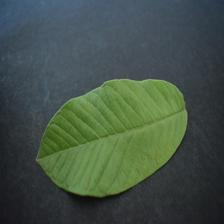


Predicted: 1, Actual: 0
158_healthy.jpg


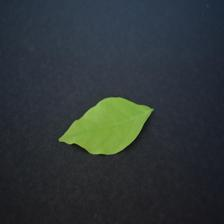


Predicted: 0, Actual: 1
182_diseased.jpg


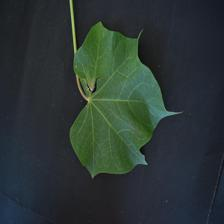


Predicted: 1, Actual: 0
186_healthy.jpg


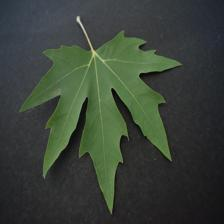


Predicted: 1, Actual: 0
22_healthy.jpg


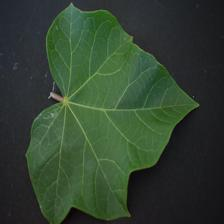


Predicted: 1, Actual: 0
23_healthy.jpg


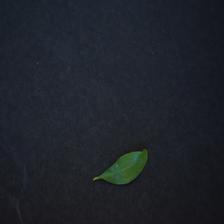


Predicted: 0, Actual: 1
46_diseased.jpg


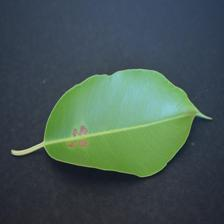

In [138]:
# Let us view the miscassified images
test_paths = os.listdir("Resized_Dataset\\test")
aug_model.eval()
for path in test_paths:
    image = load_image(f'Resized_Dataset\\test\\{path}').unsqueeze(0).to(device)
    label = 0 if (path.split('_')[1])=="healthy.jpg" else 1
    output = aug_model(image)
    _, predicted = torch.max(output.data, 1)
    if predicted != label:
        print(f"Predicted: {predicted.item()}, Actual: {label}")
        print(path)
        display(Image.open(f'Resized_Dataset\\test\\{path}'))
        print("")